In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

In [2]:
import numpy as np
import pandas as pd
import calendar

In [3]:
import datetime as dt
from datetime import date
from dateutil.relativedelta import relativedelta
from matplotlib.dates import DateFormatter

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
#get the Columns for Measurement Table
inspector = inspect(engine)
Measurement_columns = inspector.get_columns('measurement')
for column in Measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
#get the Columns for Station Table
Station_columns = inspector.get_columns('station')
for column in Station_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date)\
.order_by(Measurement.date.desc())\
.first().date
print(last_date)
print(type(last_date))

2017-08-23
<class 'str'>


In [13]:
#Get a Year ago from the last date in the Measurement Table
current_date = dt.datetime.strptime(last_date,'%Y-%m-%d').date()
prior_year = dt.datetime.strptime(last_date, '%Y-%m-%d').date() + relativedelta(years=-1)
print(current_date)
print(prior_year)

2017-08-23
2016-08-23


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
perceptation_last_year = session.query(Measurement.date, Measurement.prcp)\
.filter(Measurement.date>=prior_year)\
.order_by(Measurement.date).all()

In [15]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# I noticed N/A Values along with 0.0 vlaues Decided to drop N/A Values, since they will affect the average perceptation percent for each date.
perceptation_df = pd.DataFrame(perceptation_last_year,columns=['date', 'perceptation_percent'])
perceptation_df.set_index('date', inplace=True)
perceptation_df.head()

,perceptation_percent
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [16]:
# Perform a query to retrieve the data and precipitation scores
perceptation_df =perceptation_df.dropna()
perceptation_df.head()

,perceptation_percent
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


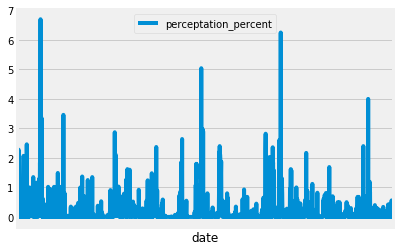

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
perceptation_df.plot()
plt.xticks([])
plt.show()

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
perceptation_df.describe()

,perceptation_percent
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [19]:
# Design a query to show how many stations are available in this dataset?
stations_count = session.query(Measurement.station)\
.group_by(Measurement.station).count()

stations_count

9

In [20]:
# What are the most active stations? (i.e. what stations have the most rows)?
stations_active = session.query(Measurement.station, func.count(Measurement.station))\
.group_by(Measurement.station)\
.order_by(func.count(Measurement.station)\
          .desc()).all()
# What are the most active stations? (i.e. what stations have the most rows)?
stations_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Finding the most Active Station Name
most_active_station = stations_active[0][0]
most_active_station

'USC00519281'

In [23]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temps_most_active_station = session.query(func.min(Measurement.tobs),\
                                          func.max(Measurement.tobs),\
                                          func.avg(Measurement.tobs)).\
filter(Measurement.station == most_active_station).all()

print(most_active_station)
print(temps_most_active_station)

USC00519281
[(54.0, 85.0, 71.66378066378067)]


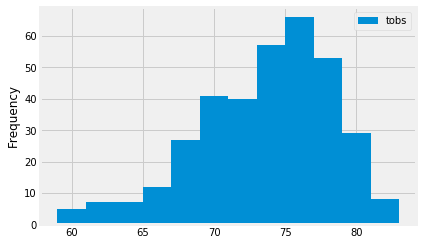

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
querystation = session.query(Measurement.tobs)\
.filter(Measurement.date >= prior_year)\
.filter(Measurement.station == most_active_station)


df_station = pd.DataFrame(querystation, columns=['tobs'])


df_station.plot.hist(bins=12,alpha=1)

plt.show()

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip_start = '2017-08-31'

my_trip_end =  '2017-09-07'

my_trip = '2017-08-31 to 2017-09-07'

my_trip_start_prior_year = dt.datetime.strptime(my_trip_start,'%Y-%m-%d').date() + relativedelta(years=-1)

my_trip_end_prior_year = dt.datetime.strptime(my_trip_end,'%Y-%m-%d').date() + relativedelta(years=-1)

temp_range = calc_temps(my_trip_start_prior_year,my_trip_end_prior_year)

temp_range

[(73.0, 77.97916666666667, 84.0)]

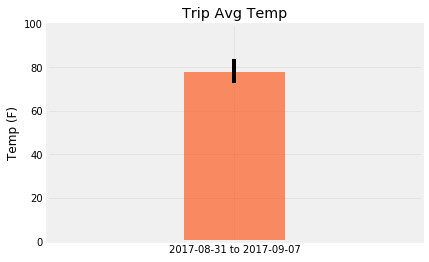

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

minTripTemp = temp_range[0][0]
avgTripTemp = temp_range[0][1]
maxTripTemp = temp_range[0][2]
minError = avgTripTemp - minTripTemp
maxError = maxTripTemp - avgTripTemp
errorBars = np.array([[minError], [maxError]])
plt.bar(my_trip, avgTripTemp, yerr=errorBars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)


In [29]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station,\
                         Station.name,\
                         Station.latitude,\
                         Station.longitude,\
                         Station.elevation,\
                         Measurement.prcp)\
.filter(Measurement.date >= my_trip_start_prior_year)\
          .filter(Measurement.date <= my_trip_end_prior_year)\
.order_by(Measurement.prcp.desc()).all()



for x in rainfall:
    print(x)


('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 2.46)
('USC00516128', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 2.46)
('USC00516128', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 2.46)
('USC00516128', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 2.46)
('USC00516128', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6, 2.46)
('USC00516128', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 2.46)
('USC00516128', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 2.46)
('USC00516128', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9, 2.46)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 2.46)
('USC00516128', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 1.35)
('USC00516128', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 1.35)
('USC00516128', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 1.35)
('USC00516128', 'PEARL CITY, HI US', 21.3934, -157.97

## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
